<a href="https://colab.research.google.com/github/vilsonrodrigues/ComputerVision/blob/master/PestControlInRice/PestControlInRice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pest Control In Rice**

Article pt-br in Medium: https://vilsonrodrigues.medium.com/construindo-um-detector-de-pragas-em-mudas-de-arroz-usando-tensor-flow-e-wandb-4f019d2916d1

## Install and import libs

### Install external libs

In [ ]:
%%capture
!pip install wandb

### Import libs

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import datetime
import pytz
import IPython
import joblib
import os
from imutils import paths
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
import wandb
from wandb.keras import WandbCallback

## Importing Dataset

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/IMD1122/ProjetoFinal/archive.zip

Whoever uploaded the dataset to Kaggle inserted 2x the data, instead of having 1 dataset with 7gb, we have 2, this ends up using a lot of Colab disk. We will delete one.

In [ ]:
! rm -r RiceLeafs

## Classes

New head to the new model

In [ ]:
#Fully connect network
class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, units, dropout_rate, num_hidden_layers):
    #Collect model output and make a starting point for inserting as new FC layers
    headModel = baseModel.output
    #Flatten layer
    headModel = tf.keras.layers.Flatten()(headModel)
    for _ in range(num_hidden_layers): 
      #Dense layers and dropout
      headModel = tf.keras.layers.Dense(units, activation = tf.nn.relu, kernel_initializer = tf.keras.initializers.HeNormal(), kernel_regularizer = tf.keras.regularizers.l2(l=0.01))(headModel)
      headModel = tf.keras.layers.BatchNormalization()(headModel)
      headModel = tf.keras.layers.Dropout(dropout_rate)(headModel)
    
    #Softmax layer
    headModel = tf.keras.layers.Dense(classes, activation = tf.nn.softmax)(headModel)
    return headModel

Convert image to array

In [ ]:
#from tensorflow.keras.preprocessing.image import img_to_array
class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		#Store formact images
		self.dataFormat = dataFormat

	def preprocess(self, image):
    #Convert images to array
		return tf.keras.preprocessing.image.img_to_array(image, data_format = self.dataFormat)

Resize images

In [ ]:
import imutils
import cv2

class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		#Store the target image width, height, and interpolation
		#method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		#Grab the dimensions of the image and then initialize
		#the deltas to use when cropping
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0

		#If the width is smaller than the height, then resize
		#along the width (i.e., the smaller dimension) and then
		#update the deltas to crop the height to the desired
		#dimension
		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		#otherwise, the height is smaller than the width so
		#resize along the height and then update the deltas
		#crop along the width
		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		#Now that our images have been resized, we need to
		#re-grab the width and height, followed by performing
		#the crop
		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		#Finally, resize the image to the provided spatial
		#dimensions to ensure our output image is always a fixed
		#size
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

Helper to load images

In [ ]:
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		#Store the image preprocessor
		self.preprocessors = preprocessors

		#if the preprocessors are None, initialize them as an
		#empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		#initialize the list of features and labels
		data = []
		labels = []

		#Loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			#load the image and extract the class label assuming
			#that our path has the following format:
			#/path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			#check to see if our preprocessors are not None
			if self.preprocessors is not None:
				#loop over the preprocessors and apply each to
				#the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			#treat our processed image as a "feature vector"
			#by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			#show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		#return a tuple of the data and labels
		return (np.array(data), np.array(labels))

Callback to storege the time consumed

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))
    print('Duration: {:.2f} seconds'.format(time.time() - self.begins))

## Prepare Dataset

### Serialing Dataset

Apply the transformations to the dataset and then save to HDF5 and Pkl

In [ ]:
def serialize_dataset(dataset, width_input_model = 224, height_input_model = 224):
  #Take the list of images that we will describe and extract
  #the names of the image path class labels
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(dataset))
  classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
  classNames = [str(x) for x in np.unique(classNames)]

  #Initializes image preprocessors
  #Where width and height are the input dimensions that VGG16 expects
  aap = AspectAwarePreprocessor(width_input_model, height_input_model)
  iap = ImageToArrayPreprocessor()

  #Load the disk data set, then scale the raw pixel intensities to
  #the range [0, 1]
  sdl = SimpleDatasetLoader(preprocessors = [aap, iap])
  (data, labels) = sdl.load(imagePaths, verbose = 500)
  data = data.astype("float") / 255.0

  #Convert labels to array
  labels_bin = LabelBinarizer().fit_transform(labels)

  #Save in hdf5
  with h5py.File("dataset224x224.h5", "w") as f:
    f.create_dataset("data", data = data)
    f.create_dataset("labels", data = labels_bin)
    f.close()
  #Export to pkl
  joblib.dump(classNames, 'classNames.pkl')
  joblib.dump(labels, 'labels.pkl')
  return classNames, data, labels

In [ ]:
classNames, data, labels = serialize_dataset(dataset = "riceleafs", width_input_model = 224, height_input_model = 224)

[INFO] loading images...
[INFO] processed 500/3355
[INFO] processed 1000/3355
[INFO] processed 1500/3355
[INFO] processed 2000/3355
[INFO] processed 2500/3355
[INFO] processed 3000/3355


In [ ]:
!ls

classNames.pkl	dataset224x224.h5  drive  labels.pkl  riceleafs  sample_data


### Save copy at google drive

In [ ]:
!cp -r dataset224x224.h5 /content/drive/MyDrive/IMD1122/ProjetoFinal/
!cp -r classNames.pkl /content/drive/MyDrive/IMD1122/ProjetoFinal/
!cp -r labels.pkl /content/drive/MyDrive/IMD1122/ProjetoFinal/

### import from Drive to Colab (If you start from here and the files are not yet in Colab)

In [ ]:
!cp -r /content/drive/MyDrive/IMD1122/ProjetoFinal/dataset224x224.h5 dataset224x224.h5
!cp -r /content/drive/MyDrive/IMD1122/ProjetoFinal/classNames.pkl classNames.pkl
!cp -r /content/drive/MyDrive/IMD1122/ProjetoFinal/labels.pkl labels.pkl

### Creation of Output Folders

In order to avoid the loss of trained models, we will use the Tensor Flow Model Checkpoint to save the best for each season, so we can continue the training in case of any problems in the google section. Each model will have its specific folder, for that it is necessary to create them inside the project folder.

In [ ]:
!mkdir /content/drive/MyDrive/IMD1122/ProjetoFinal/output_models
!mkdir /content/drive/MyDrive/IMD1122/ProjetoFinal/output_models/VGG19
!mkdir /content/drive/MyDrive/IMD1122/ProjetoFinal/output_models/RESNET152v2
!mkdir /content/drive/MyDrive/IMD1122/ProjetoFinal/output_models/EfficientNetB7

mkdir: cannot create directory ‘/content/drive/MyDrive/IMD1122/ProjetoFinal/output_models’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/IMD1122/ProjetoFinal/output_models/VGG19’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/IMD1122/ProjetoFinal/output_models/RESNET152v2’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/IMD1122/ProjetoFinal/output_models/EfficientNetB7’: File exists


### Path Definition

Declaring the path that we will save the models

In [ ]:
OUTPUT_PATH_MODELS = "/content/drive/MyDrive/IMD1122/ProjetoFinal/output_models/"

## Plot images

In [ ]:
def plot_images_dataset(path_data = "dataset224x224.h5", path_labels = "labels.pkl"):
  #Open hdf5
  dataset_hdf5 = h5py.File(path_data, "r")
  data = dataset_hdf5["data"][:]  
  dataset_hdf5.close()
  #Reading labels
  labels = joblib.load(path_labels)
  print("Number of samples per class")
  print(pd.DataFrame(labels).value_counts())
  print("Total images" + str(pd.DataFrame(labels).count()))
  plt.figure(figsize=(25,25))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(data[i*120])
      plt.xlabel(labels[i*120])    
  plt.show()

Number of samples per class
Healthy      1488
LeafBlast     779
Hispa         565
BrownSpot     523
dtype: int64
Total images0    3355
dtype: int64


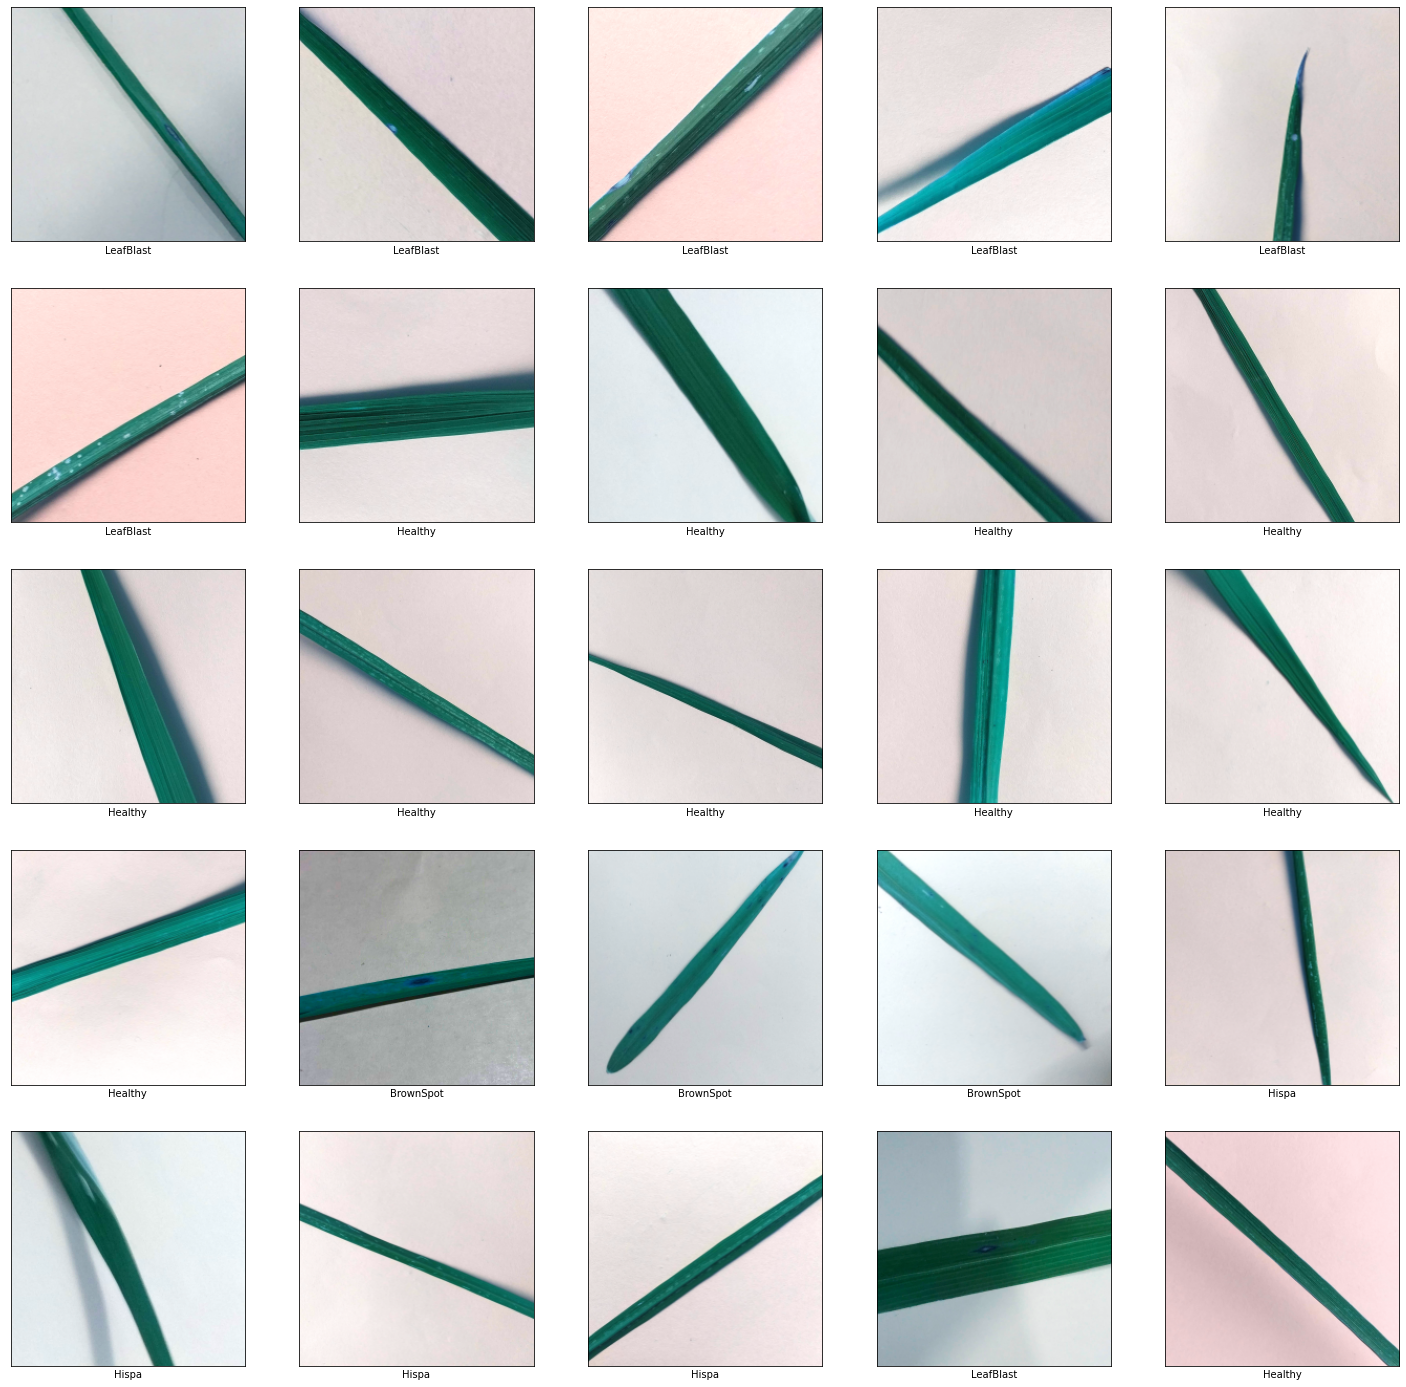

In [ ]:
plot_images_dataset()

## Building and Evaluating Models

### Train multi models

Function built to be easy to use, making it possible to train different models passing just a few parameters.
You must choose which model you want to train and go where you want to store the model's output.
The function uses Fine Tunning to generate the models, so it allows you to defrost layers, by default they are all frozen, but just pass `thaw_layers = True` and it will enable defrosting, you can control how many layers you want to defrost, the default is defrost 4 layers, but you can indicate in the parameter `num_thawed_layers = -4` that you want to defrost just two layers for example.
The function is in charge of generating a new FC layer, with `units = 256` neurons in each.

Template options in function. But nothing prevents you from adding others, you can find the list of models already trained on the [Tensor Flow](tensorflow.org/api_docs/python/tf/keras/applications/) site

*   VGG19
*   ResNet152v2
*   EfficientNetB7



You can customize how you will save your files, in [this](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) link you can see some options. And [here](https://mkaz.blog/code/python-string-format-cookbook/) you can see about the strings



```
filename = 'epochs:{epoch:03d}-loss:{loss:.3f}-val_loss:{val_loss:.3f}-val-acc:{val_categorical_accuracy:.3f}.h5' 
```



In [ ]:
def train(type_model = "VGG19", num_thawed_layers = -4, width_input_model = 224, height_input_model = 224, num_channels = 3, thaw_layers = False, units = 256, dropout_rate = 0.25, epochs = 25, num_hidden_layers = 4):

  # checkpoint files
  filepath = OUTPUT_PATH_MODELS + type_model + "/epochs:{epoch:03d}-val_acc:{val_categorical_accuracy:.2f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose=1, save_best_only = True, mode = "max")

  if type_model == "VGG19":
    #Loading VGG19
    print("[INFO] loading base model VGG19...")
    baseModel = tf.keras.applications.VGG19(weights = "imagenet", include_top = False,
                      input_tensor = tf.keras.layers.Input(shape = (width_input_model, height_input_model, num_channels)))

  elif type_model == "RESNET152v2":
    #Loading RESNET152v2
    print("[INFO] loading base model RESNET152v2...")
    baseModel = tf.keras.applications.ResNet152V2(weights = "imagenet", include_top = False,
                      input_tensor = tf.keras.layers.Input(shape = (width_input_model, height_input_model, num_channels)))

  elif type_model == "EfficientNetB7":
    #Loading EfficientNetB7
    print("[INFO] loading base model EfficientNetB7...")
    baseModel = tf.keras.applications.EfficientNetB7(weights = "imagenet", include_top = False,
                      input_tensor = tf.keras.layers.Input(shape = (width_input_model, height_input_model, num_channels)))
      
  #Reading data
  print("[INFO] read database...")
  dataset_hdf5 = h5py.File("dataset224x224.h5", "r")
  data = dataset_hdf5["data"][:]
  labels = dataset_hdf5["labels"][:]
  dataset_hdf5.close()
  #Reading class names
  classNames = joblib.load('classNames.pkl')
    
  print("[INFO] spliting database...")
  #Split 90-5-5
  #Split 1, separate into training and test data, 90% for training
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
  #Split 2, also creates training data from test data
  X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    
  print("[INFO] freezing layers...")
  #Freezing all layers
  for layer in baseModel.layers:
    layer.trainable = False

  #If I want to thaw some layers
  if thaw_layers == True:
    #Flag that indicates from which layer it should start to thaw / trainable
    print("[INFO] thaw the layers from" + str(num_thawed_layers) + "onwards...")
    for layer in baseModel.layers[num_thawed_layers:]:
      layer.trainable = True

  #Initializes the new head of the network, a set of FC layers
  #followed by a softmax classifier
  print("[INFO] creating new head Fully Connected...")
  headModel = FCHeadNet.build(baseModel = baseModel, 
                              classes = len(classNames), 
                              units = units,
                              dropout_rate = dropout_rate,
                              num_hidden_layers = num_hidden_layers)

  #Connects the base model to the new Head
  print("[INFO] connecting basemodel with new head...")
  model = tf.keras.models.Model(inputs = baseModel.input, outputs = headModel)

  print("[INFO] new model summary...")
  print(model.summary())

  print("[INFO] compiling model...")
  #OAdam
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
  #Loss function
  loss = tf.keras.losses.CategoricalCrossentropy()
  #Accuracy to multi class
  metrics = [tf.keras.metrics.CategoricalAccuracy()]
  #Compiling model
  model.compile(loss = loss, 
                optimizer = optimizer,
                metrics = metrics)

  #Read the directory  
  archives_model = os.listdir(OUTPUT_PATH_MODELS + type_model)
  #If the folder is empty
  if not archives_model:
    print("[INFO] without pre-trained weights...")
    #The starting epoch will be 0
    initial_epoch =  0
    print("[INFO] starting epoch will be 0...")
  #If the folder has a model inside
  else:
    print("[INFO] pre-trained weights identified in Drive...")
    print("[INFO] archive: " + archives_model[0] + "...")
    #Reads the number of seasons trained from the file name
    num_initial_epochs = archives_model[0][7:10]
    print("[INFO] starting epoch will be " + num_initial_epochs + "...")
    #Convert to int
    initial_epoch = int(num_initial_epochs)
    #The model with the same structure reads the weights of the Drive
    model.load_weights(OUTPUT_PATH_MODELS + type_model + "/" + archives_model[0])
    
  #Data augmentation generator
  print("[INFO] compiling model...")
  aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 30, width_shift_range = 0.1,
                          height_shift_range = 0.1, shear_range = 0.2, zoom_range = 0.2,
                          horizontal_flip = True, fill_mode = "nearest")
    
  print("[INFO] start training model...")
  history = model.fit(aug.flow(X_train, y_train, batch_size = 32),
                      validation_data = (X_dev, y_dev), 
                      epochs = epochs,
                      steps_per_epoch = len(X_train) // 32, 
                      callbacks = [MyCustomCallback(),
                                  checkpoint],
                      verbose = 1,
                      initial_epoch = initial_epoch)
    
  #Evaluate the network on the fine-tuned model
  print("[INFO] evaluating after fine-tuning...")
  predictions = model.predict(X_test, batch_size=32)
  print(classification_report(y_test.argmax(axis=1),
                              predictions.argmax(axis=1), target_names = classNames))

  #Save final model 
  print("[INFO] serializing model...")
  model.save("model_" + type_model + ".h5")
  return 



```
#Call example
train(epochs = 1, type_model = "RESNET152v2")
```



List with models and the number of layers to be unlocked

In [ ]:
list_models = ["VGG19", "RESNET152v2", "EfficientNetB7"]
list_num_thawed_layers = [-4, -15, -15]

Training one model at a time, with 50 seasons

In [ ]:
for (model_list, num_layers) in zip(list_models, list_num_thawed_layers):
  train(type_model = model_list, num_thawed_layers = num_layers, epochs = 1, thaw_layers = True)

### Train with Wandb

Logging into the Wandb account

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Username in Wandb

In [ ]:
entity = "vilsonrodrigues07"

Wandb using the Grid parameter in Sweep will select one model at a time and monitor its results.
The function will consult if there is already a model previously trained, in order to have a starting point. Let's read the string that comes in the file name to get the time that stopped the training, convert it to a whole and so we will inform the model the starting point

In [ ]:
def train():
  width_input_model = 224
  height_input_model = 224
  num_channels = 3
  thaw_layers = True

  #Default values for hyper-parameters we're going to sweep over
  defaults = dict(units = 256,
                    learning_rate = 0.0001,
                    epochs = num_epochs,
                    batch_size = 32,
                    type_model = "VGG19",
                    dropout_rate = 0.25,
                    num_hidden_layers = 1              
                  )
    

  #Initialize a new wandb run
  run = wandb.init(project = name_project, config = defaults)

  #Salva o nome da arquitetura no sweeps
  wandb.config.architecture = wandb.config.type_model

  #Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config

  #Checkpoint files
  filepath = OUTPUT_PATH_MODELS + config.type_model + "/epochs:{epoch:03d}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True)

  if config.type_model == "VGG19":
    #Loading VGG19
    print("[INFO] loading base model VGG19...")
    baseModel = tf.keras.applications.VGG19(weights = "imagenet", include_top = False,
                      input_tensor = tf.keras.layers.Input(shape = (width_input_model, height_input_model, num_channels)))
    num_thawed_layers = -4   

  elif config.type_model == "RESNET152v2":
    #Loading RESNET152v2
    print("[INFO] loading base model RESNET152v2...")
    baseModel = tf.keras.applications.ResNet152V2(weights = "imagenet", include_top = False,
                      input_tensor = tf.keras.layers.Input(shape = (width_input_model, height_input_model, num_channels)))
    num_thawed_layers = -15   

  elif config.type_model == "EfficientNetB7":
    #Loading EfficientNetB7
    print("[INFO] loading base model EfficientNetB7...")
    baseModel = tf.keras.applications.EfficientNetB7(weights = "imagenet", include_top = False,
                      input_tensor = tf.keras.layers.Input(shape = (width_input_model, height_input_model, num_channels)))
    num_thawed_layers = -15
    
  #Read data
  print("[INFO] read database...")
  dataset_hdf5 = h5py.File("dataset224x224.h5", "r")
  data = dataset_hdf5["data"][:]
  labels = dataset_hdf5["labels"][:]
  dataset_hdf5.close()
  #Read class names
  classNames = joblib.load('classNames.pkl')
  
  print("[INFO] spliting database...")
  #Spliting 90-5-5
  #Split 1, separates into training and test data, 90% for training
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
  #Split 2, also creates training data from test data
  X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
  
  print("[INFO] freezing layers...")
  #Freeze all layers
  for layer in baseModel.layers:
    layer.trainable = False

  #If I want to thaw some layers
  if thaw_layers == True:
    #Flag that indicates from which layer it should start to thaw / trainable
    print("[INFO] thaw the layers from" + str(num_thawed_layers) + "onwards...")
    for layer in baseModel.layers[num_thawed_layers:]:
      layer.trainable = True

  #Initializes the new head of the network, a set of FC layers
  #followed by a softmax classifier  print("[INFO] creating new head Fully Connected...")
  headModel = FCHeadNet.build(baseModel = baseModel, 
                              classes = len(classNames), 
                              units = config.units,
                              dropout_rate = config.dropout_rate,
                              num_hidden_layers = config.num_hidden_layers
                              )

  #Connects the base model to the new Head
  print("[INFO] connecting basemodel with new head...")
  model = tf.keras.models.Model(inputs = baseModel.input, outputs = headModel)

  print("[INFO] new model summary...")
  print(model.summary())

  print("[INFO] compiling model...")
  #Adam
  optimizer = tf.keras.optimizers.Adam(learning_rate = config.learning_rate)
  #Loss function
  loss = tf.keras.losses.CategoricalCrossentropy()
  #Accuracy to multi classes
  metrics = [tf.keras.metrics.CategoricalAccuracy()]
  #Compile model
  model.compile(loss = loss, 
                optimizer = optimizer,
                metrics = metrics)
  
  #Check the list of files inside the folder in Drive
  archives_model = os.listdir(OUTPUT_PATH_MODELS + config.type_model)
  #If the folder is empty
  if not archives_model:
    print("[INFO] without pre-trained weights...")
    #The starting season will be 0
    initial_epoch =  0
    print("[INFO] starting epoch will be 1...")
  #If the folder has a template inside
  else:
    print("[INFO] pre-trained weights identified in Drive...")
    # Reads the number of seasons trained from the file name
    num_initial_epochs = archives_model[0][7:10]
    print("[INFO] starting epoch will be " + num_initial_epochs + "...")
    #Converts the number of epochs to integer
    initial_epoch = int(num_initial_epochs)
    #The model with the same structure reads the weights of the Drive
    model.load_weights(OUTPUT_PATH_MODELS + config.type_model + "/" + archives_model[0])
  
  #Data augmentation generator
  print("[INFO] compiling model...")
  aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 30, width_shift_range = 0.1,
                          height_shift_range = 0.1, shear_range = 0.2, zoom_range = 0.2,
                          horizontal_flip = True, fill_mode = "nearest")
  
  print("[INFO] start training model...")
  history = model.fit(aug.flow(X_train, y_train, batch_size = 32),
                      validation_data = (X_dev, y_dev), 
                      epochs = config.epochs,
                      steps_per_epoch = len(X_train) // 32, 
                      callbacks = [MyCustomCallback(),
                                   checkpoint,
                                   WandbCallback()],
                      verbose = 1,
                      initial_epoch = initial_epoch)
  
  #Evaluate
  print("[INFO] evaluating after fine-tuning...")
  predictions = model.predict(X_test, batch_size=32)
  output_clf_report = classification_report(y_test.argmax(axis=1),
                              predictions.argmax(axis=1), target_names = classNames)
  print(output_clf_report)

  #Name image with classification report
  filename_clf_report = "classification_report_" + config.type_model 
  #Path to save classification report
  path_clf_report = filename_clf_report + ".jpg"
  #Create image
  image_clf_report = Image.new(mode = "RGB", size = (350,200), color = "black")
  draw = ImageDraw.Draw(image_clf_report)
  draw.text((10,10), output_clf_report, fill=(000,255,000))
  image_clf_report.save(path_clf_report)
  #Up to Wandb
  wandb.log({filename_clf_report: [wandb.Image(path_clf_report)]})
  return 

Heads tests

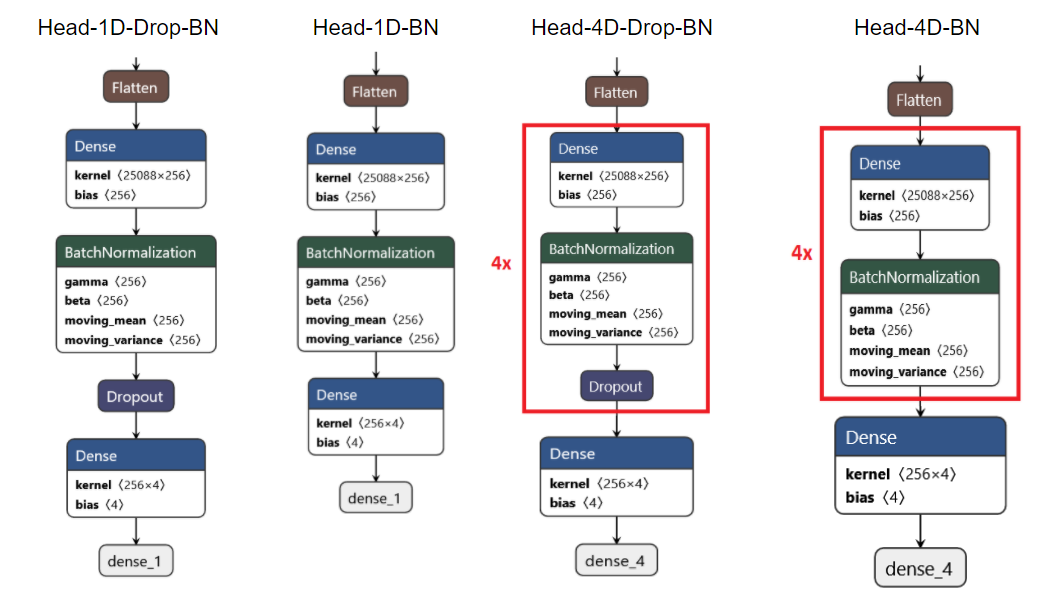

#### Step 0 - Search for better parameters with Dropout and Batch Normalization

Define name project

In [ ]:
name_project = "test_pestcontrolinrice"

Define number epochs to train

In [ ]:
num_epochs = 30

Configure the sweep to hyper tuning parameters

In [ ]:
sweep_config = {
                'method': 'grid', 
                'metric': {
                  'name': 'categorical_crossentropy',
                  'goal': 'maximize'   
                },
                'parameters': {
                  'num_hidden_layers': {
                    'values': [1,4]
                  }
                }
            }

Generate sweep id

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity = entity, project = name_project)

Start Training

In [ ]:
wandb.agent(sweep_id = sweep_id, function = train, count = 3)

#### Step 1 - Initial search for better parameters only with Batch Normalization

Define name project

In [ ]:
name_project = "test_pestcontrolinrice"

Define number epochs to train

In [ ]:
num_epochs = 30

After testing we saw that the dropout was damaging a class, so it was removed from the project. Let's run the class again

In [ ]:
#Fully connect network
class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, units, dropout_rate, num_hidden_layers):
    #Collect model output and make a starting point for inserting as new FC layers
    headModel = baseModel.output
    #Flatten layer
    headModel = tf.keras.layers.Flatten()(headModel)
    for _ in range(num_hidden_layers): 
      #Dense layers and dropout
      headModel = tf.keras.layers.Dense(units, activation = tf.nn.relu, kernel_initializer = tf.keras.initializers.HeNormal(), kernel_regularizer = tf.keras.regularizers.l2(l=0.01))(headModel)
      headModel = tf.keras.layers.BatchNormalization()(headModel)
      #headModel = tf.keras.layers.Dropout(dropout_rate)(headModel)
    
    #Softmax layer
    headModel = tf.keras.layers.Dense(classes, activation = tf.nn.softmax)(headModel)
    return headModel

Configure the sweep to hyper tuning parameters

In [ ]:
sweep_config = {
                'method': 'grid', 
                'metric': {
                  'name': 'categorical_crossentropy',
                  'goal': 'maximize'   
                },
                'parameters': {
                  'num_hidden_layers': {
                    'values': [1,4]
                  }
                }
            }

Generate sweep id

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity = entity, project = name_project)

Create sweep with ID: wi9rmw9l
Sweep URL: https://wandb.ai/vilsonrodrigues07/pestcontrolinrice/sweeps/wi9rmw9l


Start Training

In [ ]:
wandb.agent(sweep_id = sweep_id, function = train, count = 3)

Results step 0 and 1

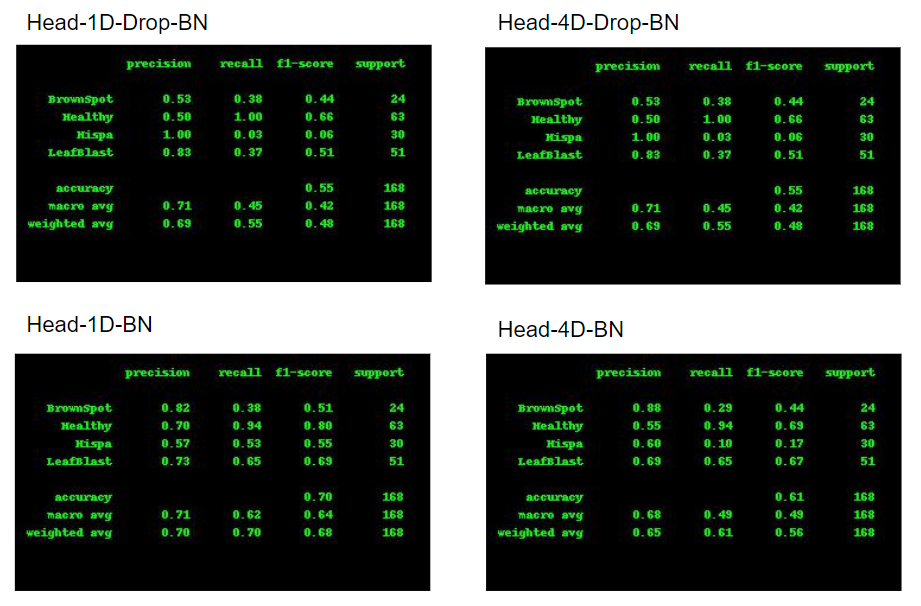

#### Step 2 - Searching for the best model using only Batch Normalization

Define name project

In [ ]:
name_project = "final_pestcontrolinrice"

Define number epochs to train

In [ ]:
num_epochs = 100

Running the FC class again without dropout

In [ ]:
#Fully connect network
class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, units, dropout_rate, num_hidden_layers):
    #Collect model output and make a starting point for inserting as new FC layers
    headModel = baseModel.output
    #Flatten layer
    headModel = tf.keras.layers.Flatten()(headModel)
    for _ in range(num_hidden_layers): 
      #Dense layers and dropout
      headModel = tf.keras.layers.Dense(units, activation = tf.nn.relu, kernel_initializer = tf.keras.initializers.HeNormal(), kernel_regularizer = tf.keras.regularizers.l2(l=0.01))(headModel)
      headModel = tf.keras.layers.BatchNormalization()(headModel)
      #headModel = tf.keras.layers.Dropout(dropout_rate)(headModel)
    
    #Softmax layer
    headModel = tf.keras.layers.Dense(classes, activation = tf.nn.softmax)(headModel)
    return headModel

Sweep Parameters 

In [ ]:
sweep_config = {
                'method': 'grid', 
                'metric': {
                  'name': 'categorical_crossentropy',
                  'goal': 'maximize'   
                },
                'parameters': {
                  'type_model': {
                    'values': ["VGG19","RESNET152v2", "EfficientNetB7"]
                  }
                }
            }

Generate sweep id

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity = entity, project = name_project)

Start Training

In [ ]:
wandb.agent(sweep_id = sweep_id, function = train, count = 3)

#### Step 3 - Searching for the best model using Dropout and Batch Normalization

Define name project

In [ ]:
name_project = "test_pestcontrolinrice"

Define number epochs to train

In [ ]:
num_epochs = 100

Class FC with dropout

In [ ]:
#Fully connect network
class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, units, dropout_rate, num_hidden_layers):
    #Collect model output and make a starting point for inserting as new FC layers
    headModel = baseModel.output
    #Flatten layer
    headModel = tf.keras.layers.Flatten()(headModel)
    for _ in range(num_hidden_layers): 
      #Dense layers and dropout
      headModel = tf.keras.layers.Dense(units, activation = tf.nn.relu, kernel_initializer = tf.keras.initializers.HeNormal(), kernel_regularizer = tf.keras.regularizers.l2(l=0.01))(headModel)
      headModel = tf.keras.layers.BatchNormalization()(headModel)
      headModel = tf.keras.layers.Dropout(dropout_rate)(headModel)
    
    #Softmax layer
    headModel = tf.keras.layers.Dense(classes, activation = tf.nn.softmax)(headModel)
    return headModel

Sweep Parameters 

In [ ]:
sweep_config = {
                'method': 'grid', 
                'metric': {
                  'name': 'categorical_crossentropy',
                  'goal': 'maximize'   
                },
                'parameters': {
                  'type_model': {
                    'values': ["VGG19","RESNET152v2", "EfficientNetB7"]
                  }
                }
            }

Generate sweep id

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity = entity, project = name_project)

Start Training

In [ ]:
wandb.agent(sweep_id = sweep_id, function = train, count = 3)

Wandb. Dropout and Batch Normalization

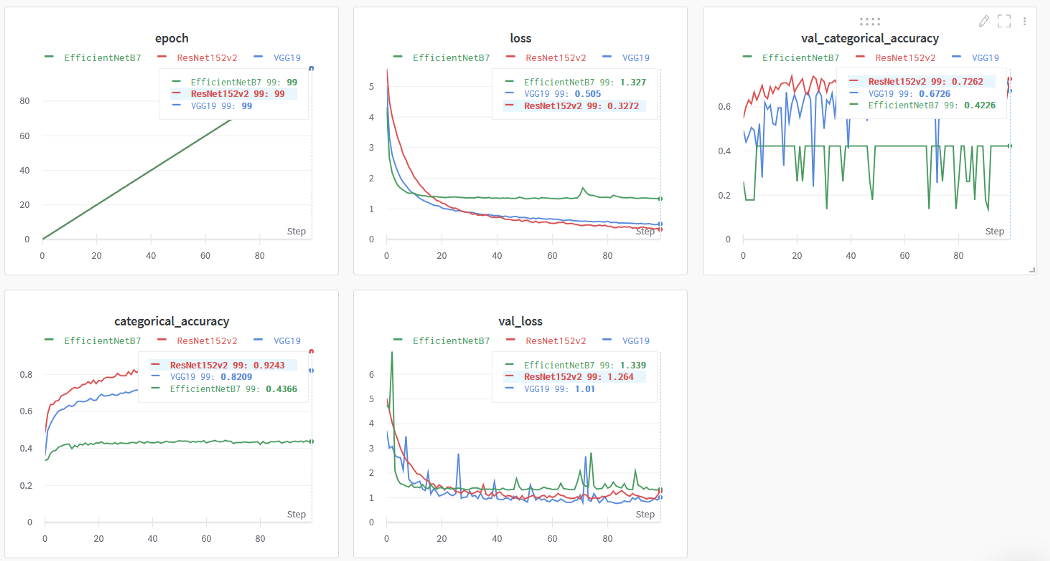

WandB. Batch Normalization 

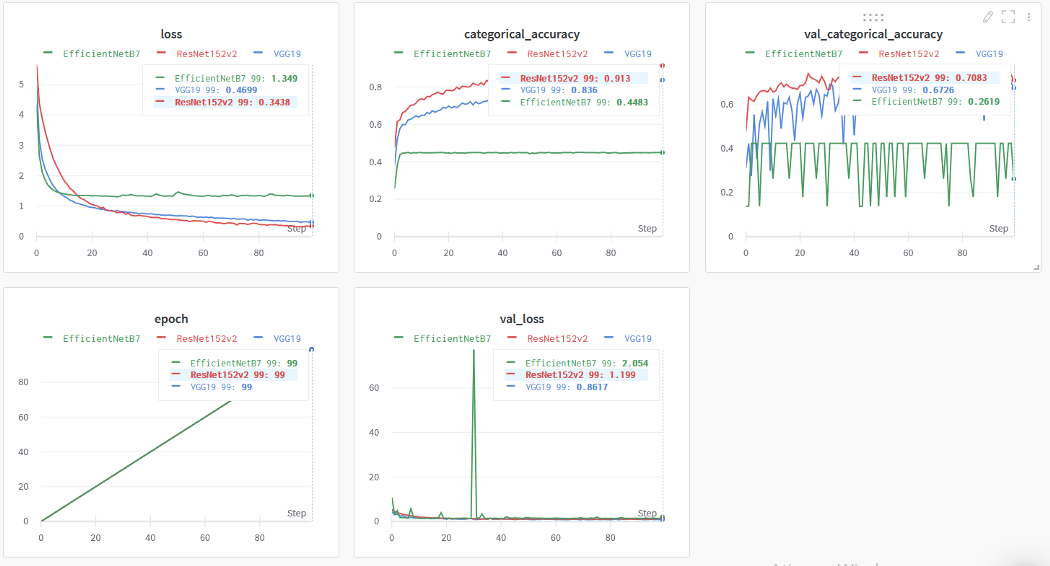

Results data test. Step 2 and 3

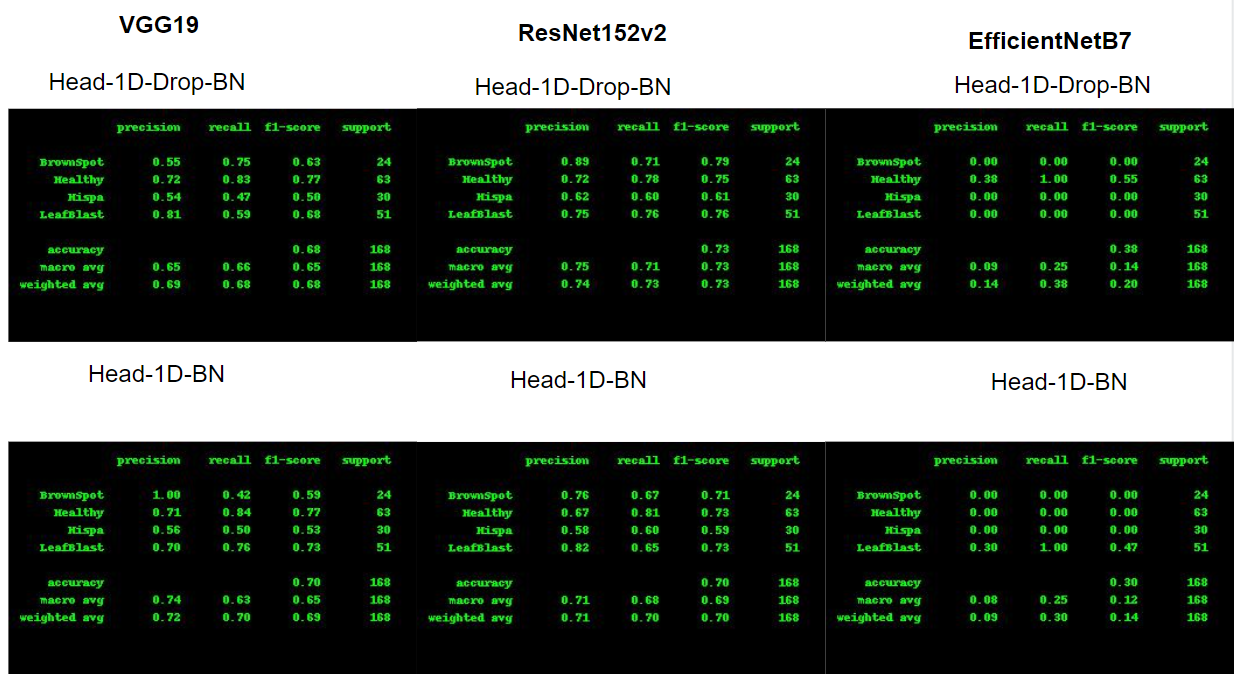